<a href="https://colab.research.google.com/github/Crimpychimp777/actions-learning-pathway/blob/main/Norm_Elias_TimeSereis_dicky%20fuller%20and%20seasonality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problem Statement:
- Use the given Catfish data and use ARIMA model to forecast.
- Split the data into training and testing set. Training data should contain all the data points until 2010-01-01 and the rest should be in the test data.

**Follow the following steps to make a forecast using ARIMA model**
- Check if the data is stationary
- If not, make the data stationary ( differencing technique)
- Plot ACF and PACF and decide the right value of p, d and q.
- Finally built a model and fit the model.
- print model summary
- plot actual vs forecasted value


##Import Necessary Libraries

In [1]:
# Load libraries for data manipulation
import pandas as pd
import numpy as np
# Libraries for data visualization
from matplotlib import pyplot as plt
import seaborn as sns

from pylab import rcParams
from statsmodels.graphics.tsaplots import month_plot, plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose,STL
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import warnings



In [7]:
# Write code to control warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [8]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load and prepare the data for Time Series analysis

In [9]:
# Load data
df= pd.read_csv('/content/drive/MyDrive/SUU Data Analytics/Module 7/catfish (1).csv')

# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Find the highest (max) and lowest (min) date values from the 'Date' column of df
oldest_date  = df['Date'].min()
newest_date  = df['Date'].max()

# Print the oldest and newest data
print("Newest_date:", newest_date.strftime('%Y-%m-%d'))
print("Oldest_date:", oldest_date.strftime('%Y-%m-%d'))

Newest_date: 2012-12-01
Oldest_date: 1986-01-01


**Let's create a montly data range to ensure equal interval of time series**

In [5]:
# Create a monthly date range to ensure equal interval of the time series
"""
Use this: start='1986-1-01',end='2013-1-01',freq ='M'
"""
timestamp = pd.date_range(start='1986-1-01',end='2013-1-01',freq ='M')

# Add a new column 'Time_Stamp' using above timestamp data
df['Time_Stamp'] = timestamp
# Since we have created a new Time_Stamp column let's drop the original Date column
if 'Date' in df.columns:
    df.drop(labels='Date',axis=1,inplace=True)
# Observe the first 5 data points
df.head()

,Total,Time_Stamp
0,9034,1986-01-31
1,9596,1986-02-28
2,10558,1986-03-31
3,9002,1986-04-30
4,9239,1986-05-31


In [6]:
# Make Time_Stamp column as your index column.
df.set_index('Time_Stamp',drop= True, inplace=True)
df.head()

,Total
Time_Stamp,
1986-01-31,9034
1986-02-28,9596
1986-03-31,10558
1986-04-30,9002
1986-05-31,9239


In [15]:
# Split the data into train and test dataset
"""
Remember: Training data should contain all the data points until 2010-01-01
and the rest should be in the test data.
"""
cat_train = df[df.index < '2010-01-01']
cat_test = df[df.index >= '2010-01-01']

## Check if the data is stationary

**Recall: Augmented Dickey-Fuller Test:** A formal test to check whether time series data follows stationary process.  
H0: Time series is non-stationary  
H1: Time series is stationary  
**let's check whether our data is stationary or not**

In [16]:
# Import library
from statsmodels.tsa.stattools import adfuller
## Write a function that gives different parameters of this test
def adf_test(data):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(data,regression = 'ct', autolag=None,maxlag=24)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


In [17]:
# Use above defined function to check different parameters of ADF test. Use training data
adf_test(cat_train['Total'])

Results of Dickey-Fuller Test:
Test Statistic                   0.870940
p-value                          1.000000
#Lags Used                      24.000000
Number of Observations Used    263.000000
Critical Value (1%)             -3.993611
Critical Value (5%)             -3.427317
Critical Value (10%)            -3.136939
dtype: float64


**Observation:**
- Use above parameters and say if the data is stationary or not.

## Make the data Stationary

In [20]:
# Calculate the first difference to make the series stationary
cat_train['Total_diff'] = cat_train['Total'].diff()
# Drop the first row containing NaN values
cat_train = cat_train.dropna()
# Apply the ADF test again
adf_test(cat_train['Total_diff'])


Results of Dickey-Fuller Test:
Test Statistic                  -4.156336
p-value                          0.005206
#Lags Used                      24.000000
Number of Observations Used    261.000000
Critical Value (1%)             -3.993881
Critical Value (5%)             -3.427447
Critical Value (10%)            -3.137015
dtype: float64


**Observation:**

### Plot ACF and PACF plot and decide the right value of pdq

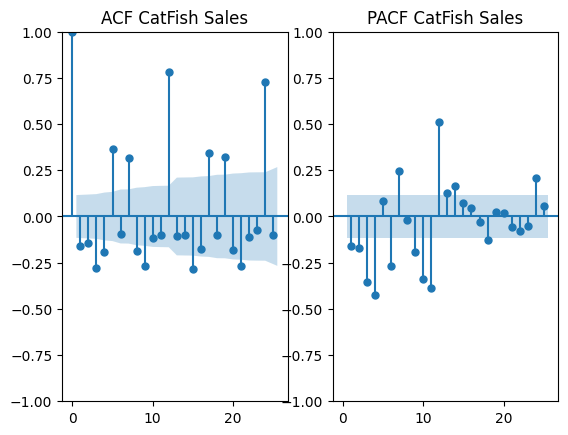

In [21]:
# import libraries
from statsmodels.graphics.tsaplots import  plot_acf,plot_pacf
# ACF and PACF after taking first difference
f,a = plt.subplots(1,2,sharex=True,sharey=False,squeeze=False)
#Plotting the ACF and the PACF
plot_0 = plot_acf(cat_train['Total_diff'],title='ACF CatFish Sales',ax=a[0][0])
plot_1 = plot_pacf(cat_train['Total_diff'],title='PACF CatFish Sales',zero= False,ax=a[0][1]);

The ACF and PACF plot shows correlation of many lags. It is difficult to decide which lag is the best lag to pass in the ARIMA model. So, let'd conduct grid search and ask python the best values of p d and q.

In [22]:
# Define a function to perform grid search for ARIMA parameters (p, d, q)
# Import ARIMA model
from statsmodels.tsa.arima.model import ARIMA

def grid_search_arima(cat_train, p_values, d_values, q_values):
    best_p, best_d, best_q = None, None, None
    best_aic = float('inf')

    # Iterate over all combinations of p, d, and q
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    # Fit ARIMA model for each combination of p, d, q
                    model = ARIMA(cat_train['Total'], order=(p, d, q))
                    fitted_model = model.fit()

                    # Calculate AIC for the fitted model
                    model_aic = fitted_model.aic

                    # If the model's AIC is the best so far, store the parameters
                    if model_aic < best_aic:
                        best_aic = model_aic
                        best_p, best_d, best_q = p, d, q
                except:
                    continue  # Skip combinations that result in an error (e.g., non-stationary data)

    return best_p, best_d, best_q, best_aic

# Define ranges for p, d, q
p_values = range(0, 4)  # Range for p (AR term)
d_values = range(0, 2)  # Range for d (Differencing term)
q_values = range(0, 4)  # Range for q (MA term)

# Perform grid search to find the best parameters
best_p, best_d, best_q, best_aic = grid_search_arima(cat_train, p_values, d_values, q_values)

print(f"Best ARIMA Parameters: p={best_p}, d={best_d}, q={best_q}")
print(f"Best AIC: {best_aic}")

Best ARIMA Parameters: p=3, d=1, q=2
Best AIC: 5006.076776618553


## Build and fit the model

In [24]:
# Define the ARIMA model (p, d, q) - Use the value of p d and q given by the previous grid search.
model = ARIMA(cat_train['Total'], order=(best_p, best_d, best_q))

# Fit the model
fitted_model = model.fit()

# Forecasting the next len(cat_test) periods
forecast = fitted_model.forecast(len(cat_test))

## Print model summary

In [25]:
# Print the summary of the ARIMA model
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  286
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -2497.038
Date:                Sat, 21 Feb 2026   AIC                           5006.077
Time:                        14:41:17   BIC                           5027.992
Sample:                    03-31-1986   HQIC                          5014.862
                         - 12-31-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5982      0.079      7.543      0.000       0.443       0.754
ar.L2         -0.5951      0.077     -7.692      0.000      -0.747      -0.443
ar.L3         -0.3951      0.079     -4.992      0.0

**Observation:**
This fitted ARIMA model provides insights into the accuracy and parameters. The key data to focus on are: standard errors, z-stat, and p-values. The P-value is less than .05 meaning this data isnt just random and there is a pattern that is something to be researched. Moreover, we would reject the null and go with our alternative that this data is not random and the sales show significant patterns. Stats like AIC, BIC and HQIC are scores that help choose our best model and the lower the score the more accurate and smart the model is. The Ljung Box test checks if the residual erros after the model are just random or distinct. After reviewing the data the P value is low and could potentially indicate that there are more hidden patterns hiding in the datas errors. we could manipulate the p/q or switch to SARIMA to address seasonality in this data.
- The catfish data tracksa monthly U.S. catfish sales in total pounds from January 1986 to December 2012, the trend is a clear and noticeable incline with some seasonal trends (ups and downs). The most important patterns are the growth over time in this "time-series" analysis but also the seasonality and sales in warmer months to sales in winter months and this trend repeats itself.

### Plot Actual vs Forecasted value

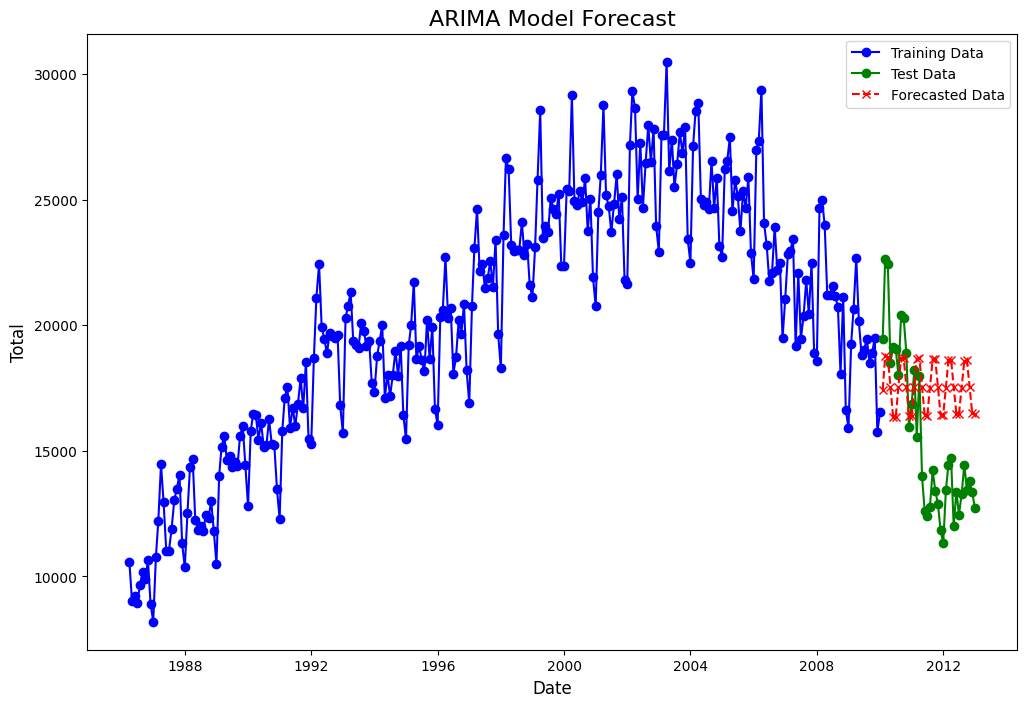

In [26]:
# Plot actual cat_train, cat_test, and forecasted values
plt.figure(figsize=(12, 8))       # Set figsize to (12,8)
plt.plot(cat_train.index, cat_train['Total'] , label='Training Data', color='blue', marker='o')             # Plot cat_train
plt.plot(cat_test.index, cat_test['Total'], label='Test Data', color='green', marker='o')                # Plot cat_test
plt.plot(cat_test.index, forecast, label='Forecasted Data', color='red', linestyle='--', marker='x')  # Plot forecasted value

# Add labels and title
plt.title('ARIMA Model Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total', fontsize=12)
plt.legend()

# Display the plot
plt.show()



**THE END**